In [1]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from IPython.core.display import Image as IPImage

# is GPU available?
gpu = torch.cuda.is_available()

# defining device where to to the computation
device = torch.device(0) if gpu else torch.device("cpu")
device

device(type='cuda', index=0)

In [2]:
# Set the folder with the samples (images) that compose a dataset and the number of classes

orig_dir   = '../Dataset/Compiled/Classification/'
nclasses   = 9

# Set the desired image size for rescaling and maximum value for normalization

width       = 341 
height      = 256
nchannels   = 3
maxval      = 255. 
input_shape = (nchannels,height,width)

# Create training, validation, and test sets.

trainset = glob("H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Classification/Train"+"/*.jpg")
validset = glob("H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Classification/Valid"+"/*.jpg")
testset  = glob("H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Classification/Test"+"/*.jpg")

# Set output model name

model_name  = 'FishCNN.pth'

In [3]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized, 
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters. 

prep = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias='True'),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

aug = transforms.Compose([
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias='True'),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias='True'),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        self.targets   = [int(str(x).split("\\")[-1].split("_")[0]) for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)        
    def __getitem__(self, ix): # returns the item at position ix 
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()                  
        return(image,target)
    def get_path(self, ix):
        return self.dataset[ix]

In [4]:
trainset = ImageDataset(trainset, prep) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

Number of images: 8600

Images are 341x256x3

Class of the image:  1

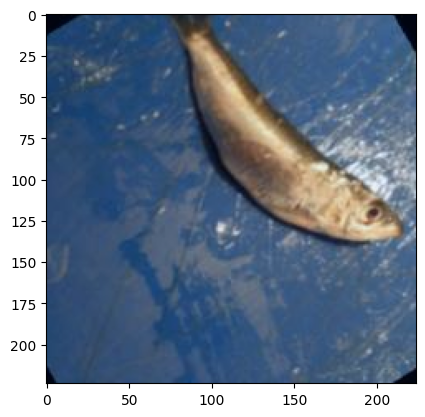

In [5]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[10] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

In [6]:
batchsize = 100
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

inspect(next(iter(trainload))) # inspect a couple of items in the batches

══════════════════════════════════════════════════════════════════

list of 2 items

Tensor  Shape: torch.Size([100, 3, 224, 224])   Min: -2.118     Max: 2.640      Mean: -0.069    dtype: 
torch.float32 @ cpu

Tensor  Shape: torch.Size([100])        Min: 0.000      Max: 8.000      Mean: 3.430     dtype: torch.int64 
@ cpu

══════════════════════════════════════════════════════════════════

In [7]:
def Criterion(model, preds, targets):
    ce = nn.CrossEntropyLoss().to(device)
    loss = ce(preds, targets.long())
    # compute mean accuracy in the batch
    pred_labels = torch.max(preds, 1)[1]  # same as argmax
    acc = torch.sum(pred_labels == targets.data)
    n = pred_labels.size(0)
    acc = acc/n
    return loss, acc


# a convolutional block
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        # defining convolutional layer
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(3, 3),
                  stride=1, padding=1),
        # defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        # defining activation layer
        nn.ReLU(),
        # defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )


class FishNet(nn.Module):

    def __init__(self, input_shape, num_classes):
        super(FishNet, self).__init__()

        # defining feature extractor
        self.features = nn.Sequential(
            conv_block(input_shape[0], 32, 2),
            conv_block(32, 64, 2),
            conv_block(64, 128, 2),
            conv_block(128, 256, 2)
        )

        # defining classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=50176, out_features=128, bias=True),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(128, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(256, 64, bias=True),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(64, num_classes)
        )

        # initialize weights
        self._initialize_weights()

    def forward(self, x):
       # extracts features
        x = self.features(x)

        # transforms outputs into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        # classifies features
        y = self.classifier(x)

        return y

    def _initialize_weights(self):
        # for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                # initialize layer weights with random values generated from a normal
                # distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    # initialize bias with 0
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                # initialize layer weights with random values generated from a normal
                # distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                    # initialize bias with 0
                    m.bias.data.zero_()

In [8]:
model = FishNet([3, width, height], nclasses).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0001)
criterion = Criterion
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [9]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    return loss.item(), acc.item()

In [10]:
# initializing variables
n_epochs = 20
log      = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        #report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%2==0: log.report_avgs(ex+1)
    lr_scheduler.step()

EPOCH: 2.000  trn_acc: 0.645  trn_loss: 0.782  val_loss: 1.127  val_acc: 0.524  (49.29s - 443.63s remaining)
EPOCH: 4.000  trn_acc: 0.817  trn_loss: 0.418  val_loss: 0.629  val_acc: 0.811  (95.23s - 380.90s remaining)
EPOCH: 6.000  trn_acc: 0.910  trn_loss: 0.250  val_loss: 0.934  val_acc: 0.712  (140.88s - 328.72s remaining)
EPOCH: 8.000  trn_acc: 0.952  trn_loss: 0.158  val_loss: 0.692  val_acc: 0.807  (186.73s - 280.10s remaining)
EPOCH: 10.000  trn_acc: 0.972  trn_loss: 0.096  val_loss: 1.171  val_acc: 0.729  (232.61s - 232.61s remaining)
EPOCH: 12.000  trn_acc: 0.980  trn_loss: 0.079  val_loss: 0.707  val_acc: 0.873  (278.75s - 185.84s remaining)
EPOCH: 14.000  trn_acc: 0.982  trn_loss: 0.063  val_loss: 1.301  val_acc: 0.762  (325.78s - 139.62s remaining)
EPOCH: 16.000  trn_acc: 0.986  trn_loss: 0.050  val_loss: 1.936  val_acc: 0.740  (371.81s - 92.95s remaining)
EPOCH: 18.000  trn_acc: 0.988  trn_loss: 0.048  val_loss: 0.839  val_acc: 0.866  (419.46s - 46.61s remaining)
EPOCH: 20

  0%|          | 0/121 [00:00<?, ?it/s]

100%|██████████| 121/121 [00:00<00:00, 4791.27it/s]


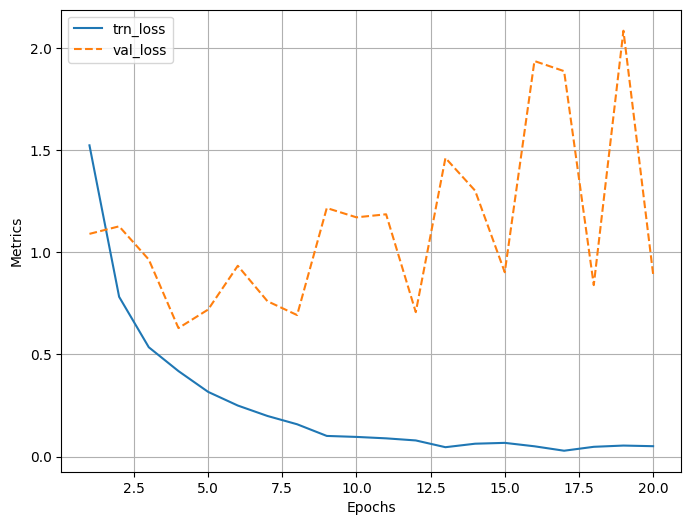

100%|██████████| 121/121 [00:00<00:00, 6188.17it/s]


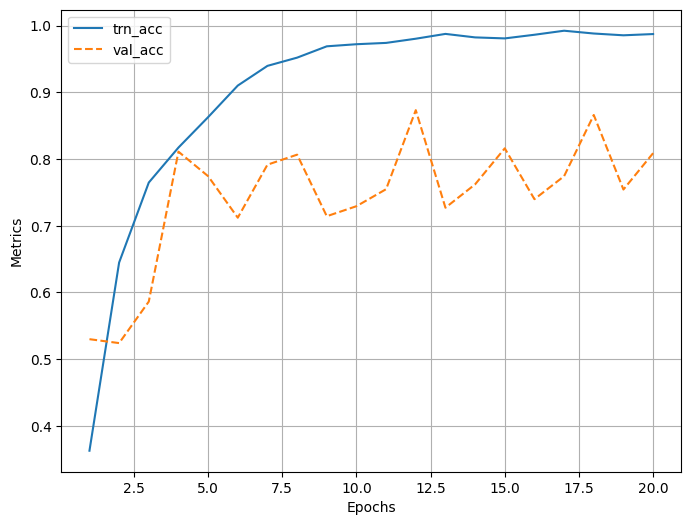

In [11]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

In [12]:
def get_activations(model, x, device):
    # move input tensor x to the selected device
    x = x.to(device)
    # get activations after feature extraction
    x = model.features[0](x)
    x = model.features[1](x)
    x = model.features[2](x)
    x = model.features[3](x)
    return x


def get_output_of_the_model(model, x, device):
    # put the model in the evaluation mode
    model.eval()
    # move input tensor x to the selected device
    x = x.to(device)
    # execute the model with gradients
    output = model(x)
    return (output)


def get_heatmap(model, x, device, model_name, labels_map):
    # add one dimension (dim=0 must be the number of images)
    xin = x.unsqueeze(0)

    # get the output of the feature extractor
    activ = get_activations(model, xin, device)

    # get the predictions at the output of the decision layer
    logits = get_output_of_the_model(model, xin, device)

    # get the most confident prediction
    pred = logits.max(-1)[-1]
    print("predicted label: ", labels_map[pred.cpu().detach().numpy()[0]])

    # compute gradients with respect to the most confident prediction
    model.zero_grad()
    logits[0, pred].backward(retain_graph=True)

    print(activ.shape)
    # only conv2D generates gradients in the feature extractor: extracts them.
    for layer_name, layer in model.features[0].named_children():
        if layer_name == '0':
            grad1 = layer.weight.grad
            nchannels1 = grad1.shape[0]
            # compute the weighted mean of the activations across channels using the mean value of the gradient
            # of each filter parameter as weight.
            for i in range(16):
                activ[:, i, :, :] *= grad1[i].mean()

    heatmap = torch.mean(activ, dim=1)[0].cpu().detach()

    # convert to numpy, normalize, and resize to the input size
    heatmap = heatmap.squeeze(0).numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = cv2.resize(heatmap, (x.shape[2], x.shape[1]))
    return (heatmap)


def display_image_with_heatmap(img, heatmap, scale):
    heatmap = np.uint8(255.0*heatmap)
    width = int(heatmap.shape[1]*scale)
    height = int(heatmap.shape[0]*scale)
    heatmap = cv2.resize(heatmap, (width, height))
    img = cv2.resize(img, (width, height))
    heatmap = cv2.applyColorMap(255-heatmap, cv2.COLORMAP_JET)
    heatmap = np.uint8(heatmap)
    heatmap = np.uint8(heatmap*0.7 + img*0.3)
    plt.imshow(heatmap)
    plt.show()

true label:  Gilt Head Bream

Photo path:  H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Classification/Test\001_00019.jpg

predicted label:  Gilt Head Bream

torch.Size([1, 256, 14, 14])

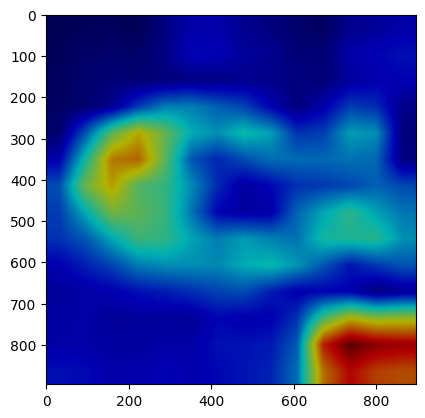

In [15]:
# get the first image tensor
labels_map = {
    0: "Black Sea Sprat",
    1: "Gilt Head Bream",
    2: "Hourse Mackerel",
    3: "Red Mullet",
    4: "Red Sea Bream",
    5: "Sea Bass",
    6: "Shrimp",
    7: "Striped Red Mullet",
    8: "Trout",
}

x = testset[15][0]
true_label = testset[15][1]
print("true label: ", labels_map[true_label])
print("Photo path: ", testset.get_path(15))
heatmap = get_heatmap(model, x, device, model_name, labels_map)
x = x.permute(1, 2, 0).numpy()
if x.shape[2] == 1:  # convert it to three channels
    x = x.squeeze(2)
    x = np.stack((x,) * 3, axis=-1)
display_image_with_heatmap(x, heatmap, 4)